In [1]:
!pip install kaggle

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing the Dog vs Cat Dataset from Kaggle

In [7]:
# Kaggle api
!kaggle datasets download shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 96% 758M/788M [00:12<00:00, 65.4MB/s]
100% 788M/788M [00:12<00:00, 66.1MB/s]


In [8]:
# extracting the compressed dataset
from zipfile import ZipFile

dataset = '/content/dataset.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [110]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from PIL import Image
import cv2
import numpy as np
import glob
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tf_keras

In [43]:
img = Image.open('/content/dataset/cat_0.jpg')
width, height = img.size

print(f"Width: {width}, Height: {height}")


Width: 500, Height: 375


In [45]:
original_folder = '/content/dataset/'
resized_folder = '/content/imageresized/'

for i in range(2000):

  filename = os.listdir(original_folder)[i]
  img_path = original_folder+filename

  img = Image.open(img_path)
  img = img.resize((224, 224))
  img = img.convert('RGB')

  newImgPath = resized_folder+filename
  img.save(newImgPath)

In [46]:
file_names = os.listdir('/content/imageresized')
dog_count = 0
cat_count = 0

for img_file in file_names:

  name = img_file[0:3]

  if name == 'dog':
    dog_count += 1

  else:
    cat_count += 1

print('Number of dog images =', dog_count)
print('Number of cat images =', cat_count)

Number of dog images = 994
Number of cat images = 1006


In [47]:
img = Image.open('/content/imageresized/cat_10039.jpg')
width, height = img.size

print(f"Width: {width}, Height: {height}")


Width: 224, Height: 224


In [48]:
filenames = os.listdir('/content/imageresized/')
labels = []
for i in range(2000):
  file_name = filenames[i]
  label = file_name[0:3]
  if label == 'dog':
    labels.append(1)
  else:
    labels.append(0)

In [54]:
image_directory = '/content/imageresized/'
image_extension = ['png', 'jpg']

files = []

[files.extend(glob.glob(image_directory + '*.' + e)) for e in image_extension]

dog_cat_images = np.asarray([cv2.imread(file) for file in files])

In [55]:
type(dog_cat_images)

numpy.ndarray

In [56]:
print(dog_cat_images.shape)

(2000, 224, 224, 3)


In [57]:
X = dog_cat_images
Y = np.asarray(labels)

In [59]:
X_train , X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [60]:
X_train_scaled = X_train/255

X_test_scaled = X_test/255

In [106]:
mobilenet_v2_link ='https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
mobilenet_v2_layer = hub.KerasLayer(mobilenet_v2_link,
                                    input_shape=(224,224,3),
                                    trainable=False)
model = tf_keras.Sequential([
  mobilenet_v2_layer,
  tf_keras.layers.Dense(2)
])


In [107]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [108]:
history = model.fit(X_train_scaled, Y_train, epochs=5)

Epoch 1/5
50/50 [==============================] - 33s 617ms/step - loss: 0.1816 - acc: 0.9269
Epoch 2/5
50/50 [==============================] - 31s 609ms/step - loss: 0.0662 - acc: 0.9750
Epoch 3/5
50/50 [==============================] - 32s 648ms/step - loss: 0.0542 - acc: 0.9812
Epoch 4/5
50/50 [==============================] - 31s 619ms/step - loss: 0.0417 - acc: 0.9875
Epoch 5/5
50/50 [==============================] - 31s 630ms/step - loss: 0.0327 - acc: 0.9894


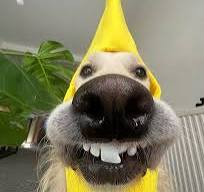

1/1 [==============================] - 0s 42ms/step
[[-2.9154031   0.74333215]]
1
The image represents a Dog


In [111]:
input_image = Image.open("/content/try.jpeg")
input_image = cv2.imread("/content/try.jpeg")
cv2_imshow(input_image)
input_image_resize = cv2.resize(input_image, (224,224))
input_image_scaled = input_image_resize/255
image_reshaped = np.reshape(input_image_scaled, [1,224,224,3])
input_prediction = model.predict(image_reshaped)

print(input_prediction)
input_pred_label = np.argmax(input_prediction)
print(input_pred_label)
if input_pred_label == 0:
  print('The image represents a Cat')
else:
  print('The image represents a Dog')

In [121]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
print("Total layers in MobileNetV2:", len(base_model.layers))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers in MobileNetV2: 154


In [122]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [131]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)


In [132]:
fine_tune_epochs = 5
total_epochs = 5 + fine_tune_epochs

history_fine = model.fit(
    X_train_scaled, Y_train,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],

)


Epoch 5/10
50/50 [==============================] - 34s 647ms/step - loss: 0.0343 - acc: 0.9881
Epoch 6/10
50/50 [==============================] - 32s 634ms/step - loss: 0.0237 - acc: 0.9944
Epoch 7/10
50/50 [==============================] - 32s 640ms/step - loss: 0.0177 - acc: 0.9969
Epoch 8/10
50/50 [==============================] - 33s 654ms/step - loss: 0.0149 - acc: 0.9981
Epoch 9/10
50/50 [==============================] - 31s 623ms/step - loss: 0.0106 - acc: 0.9987
Epoch 10/10
50/50 [==============================] - 33s 652ms/step - loss: 0.0097 - acc: 1.0000


In [138]:
acc = history.history['acc'] + history_fine.history['acc']

loss = history.history['loss'] + history_fine.history['loss']


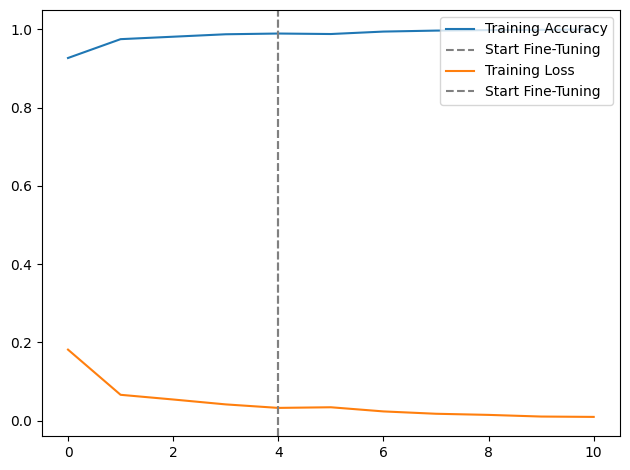

In [142]:
import matplotlib.pyplot as plt
plt.plot(acc, label='Training Accuracy')
plt.axvline(x=len(history.history['acc'])-1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')

plt.plot(loss, label='Training Loss')
plt.axvline(x=len(history.history['loss'])-1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [143]:
model.save('ImageNet(Cats vs Dogs).h5')

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
